# Изучение базы данных и анализ спроса пассажиров на рейсы в города, где проходят крупнейшие фестивали.

1. [**Подготовка данных к анализу.**](#100101)
2. [**ТОП 10 городов по количеству рейсов.**](#100102)
3. [**График количества выполненных рейсов по моделям самолетов.**](#100103)
4. [**График количества выполненных рейсов в города.**](#100104)
5. [**График количества выполненных рейсов в топ-10 городов с самым большим трафиком.**](#100105)
6. [**Проверка гипотезы от том, что средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.**](#100106)
7. [**Выводы.**](#100107)

In [6]:
import pandas as pd
f=pd.read_csv('query_1.csv')
c=pd.read_csv('query_3.csv')
bil=pd.read_csv('query_last.csv')

from nltk.stem import SnowballStemmer
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import math
import numpy as np
import seaborn as sns
from scipy import stats as st

### 1. Подготовка данных к анализу <a id='100101'></a>

In [7]:
#посмотрим на данные:
def view(d, only_numeric=True, full_stats=False, histograms=True):
    # импорт библиотек
    #import pandas as pd
    #import numpy as np
    #import matplotlib.pyplot as plt
    from IPython.display import display, HTML
    """
    Функция выводит общую информаицю по данным:
        1. Первые строки
        2. Метод info()
        3. Метод describe() - для числовых / категориальных признаков
        4. Кол-во пропусков в данных (кол-во и процент для каждого столбца)
        5. Топ-5 самых частотных категоральных признаков (для каждого)
    Параметры:
        d - таблица с данными
        only_numeric - True/False, default: True. True - вывод информации только по числовым признакам,
                        False - вывод информации по числовым и категориальным признакам.
        full_stats - True/False, default: False. False - вывод информации по числовым признакам без 
                        интерквартильного размаха, границ данных без выбросов, True - полный вывод с данными хар-ми.              
        histograms -   True/False, default: True. True - вывод с построением гистограмм для числовых признаков,
                        False - без построения гистограмм
    Топ-5 элементов категориальных признаков
        Таблица формируется следующим образом. К названию столбца данных приписывается постфикс (_name/_count).
        _name - имя категории
        _count - кол-во элементов в данной категории
        
        Если элементов в признаке менее 5, то значения в поле _count заполняются -1
    """
    print("\033[1mРазмер данных:\033[0m {}".format(d.shape))
    
    print("\n\033[1mОбзор первых строк данных\033[0m")
    print(100*'-')
    display(HTML(d.head().to_html()))
    
    print("\n\033[1mТипы данных и кол-во непустых строк\033[0m")
    print(100*'-')
    display(HTML(pd.DataFrame(d.info()).to_html()))
    
    print("\n\033[1mНаличие дат (месяц, год, день) или id в названиях столбцов\033[0m")
    print(100*'-')
    
    data_types = pd.DataFrame()
    filter_columns = []
    for col in d.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            filter_columns.append(col)
            temp = {'Имя':col, 
                        'Текущий тип':d[col].dtypes,
                        'Рекомендуемый тип':'datetime или int'}
            data_types = data_types.append(pd.DataFrame.from_dict(temp, orient='index').T)
        if 'year' in col.lower() or 'month' in col.lower() or 'day' in col.lower() or 'id' in col.lower() or 'uuid' in col.lower():
            filter_columns.append(col)
            temp = {'Имя':col, 
                        'Текущий тип':d[col].dtypes,
                        'Рекомендуемый тип':'int'}
            data_types = data_types.append(pd.DataFrame.from_dict(temp, orient='index').T)
    if data_types.shape[0] != 0:
        #print(filter_columns)
        display(HTML(data_types.set_index('Имя').to_html()))
    else:
        print("Столбцов с упоминанием даты или id нет!")
    
    print("\n\033[1mКол-во пропусков в данных\033[0m")
    print(100*'-')
    numbers_of_nulls = pd.DataFrame(columns=['Имя'], data=d.columns)
    numbers_of_nulls['Пропуски'] = d.isnull().sum().values
    numbers_of_nulls['Пропуски, %'] = 100*d.isnull().sum().values/d.shape[0]
    display(HTML(numbers_of_nulls.set_index('Имя').to_html()))
    
    print("\n\033[1mКол-во дубликатов в данных\033[0m")
    print(100*'-')
    print(d.duplicated().sum())
    
    # делим данные на числовые и категориальные
    # для числовых посчитаем среднее/медиану/квартили и IQR и кол-во выбросов методом интерквартильного размаха
    print("\n\033[1mОписательные статистики числовых признаков\033[0m")
    print(100*'-')
    d_without_date_id = d.drop(filter_columns, axis=1)
    if d_without_date_id.select_dtypes(np.number).shape[1] != 0:
        dsc = d_without_date_id.describe(include=np.number).T
        dsc['IQR'] = dsc['75%'] - dsc['25%']
        dsc['min_out'] = dsc['25%'] - 1.5 * dsc['IQR']
        dsc['max_out'] = dsc['75%'] + 1.5 * dsc['IQR']
        outliers = []
        for col in dsc.index:
            outliers.append(d_without_date_id[(d_without_date_id[col] < dsc.loc[col, 'min_out']) | (d_without_date_id[col] > dsc.loc[col, 'max_out'])].shape[0])
        dsc['number_of_outliers'] = outliers
        dsc['count'] = dsc['count'].astype('int')
        if full_stats:
            display(HTML(dsc.to_html()))
        else:
            display(HTML(dsc.drop(['min_out', 'max_out', 'IQR'], axis=1).to_html()))
    else:
        print("В данных нет числовых признаков!")
    
    if histograms:
        print('\n\033[1mГистограммы числовых показателей\033[0m')
        print(100*'-')
        d_without_date_id.select_dtypes(include=np.number).hist(figsize = (12, 12), bins = 20, color='#00ffea', alpha=0.75)
        plt.show()
    
    print("\n\033[1mОписательные статистики категориальных признаков\033[0m")
    print(100*'-')
    if d.select_dtypes('object').shape[1] != 0:
        if not only_numeric:
            temp = pd.DataFrame()
            for col in d.select_dtypes('object').columns:
                # подсчет числа каждого уникального элемента и сортировка по убыванию
                # выбираем только топ-5
                t = d[col].value_counts()[:5]
                if t.shape[0] < 5:
                    # заполням -1 если элементов не хватает до 5
                    for _ in range(5 - t.shape[0]):
                        t = t.append(pd.Series([-1]))
                # формирум таблицу
                temp[col + '_name'] = t.index
                temp[col + '_count'] = t.values

            # вывод метода describe для категориальнх элементов
            dsc = d.describe(exclude=np.number).T
            display(HTML(dsc.to_html()))
            # вывод таблицы с топ-5 каждого категориального элемента
            print("\n\n\033[1mТоп-5 уникального категориального признака\033[0m")
            print(100*'-')
            display(HTML(temp.to_html()))
    else:
        print("В данных нет категориальных признаков!")

Размер данных: (8, 2)

Обзор первых строк данных
----------------------------------------------------------------------------------------------------


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300



Типы данных и кол-во непустых строк
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


""



Наличие дат (месяц, год, день) или id в названиях столбцов
----------------------------------------------------------------------------------------------------
Столбцов с упоминанием даты или id нет!

Кол-во пропусков в данных
----------------------------------------------------------------------------------------------------


,Пропуски,"Пропуски, %"
Имя,,
model,0,0.0
flights_amount,0,0.0



Кол-во дубликатов в данных
----------------------------------------------------------------------------------------------------
0

Описательные статистики числовых признаков
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,number_of_outliers
flights_amount,8,2035.625,1965.203947,300.0,605.25,795.0,4250.25,4557.0,0



Гистограммы числовых показателей
----------------------------------------------------------------------------------------------------


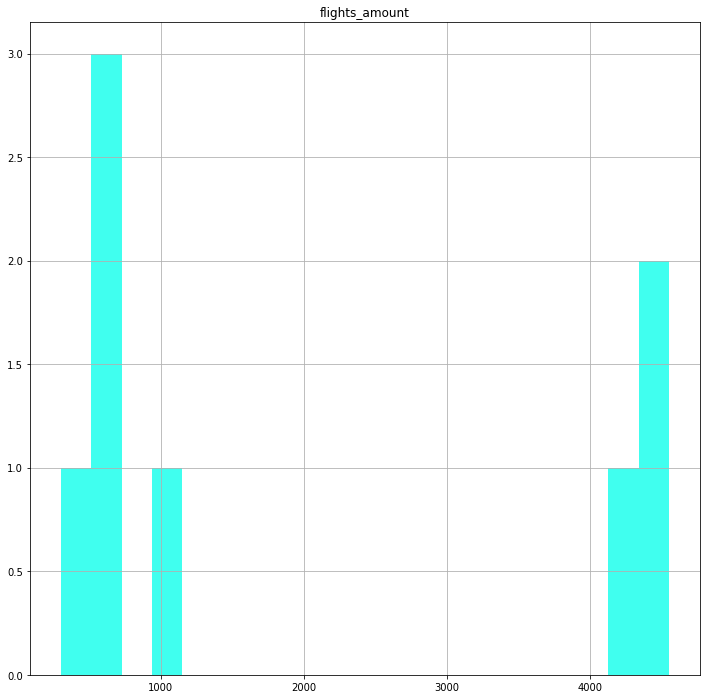


Описательные статистики категориальных признаков
----------------------------------------------------------------------------------------------------


In [8]:
view(f)

* с данными в таблице с моделями самолетов все в порядке, пропусков нет и типы данных соответствуют поставленным задачам.

Размер данных: (101, 2)

Обзор первых строк данных
----------------------------------------------------------------------------------------------------


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613



Типы данных и кол-во непустых строк
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


""



Наличие дат (месяц, год, день) или id в названиях столбцов
----------------------------------------------------------------------------------------------------
Столбцов с упоминанием даты или id нет!

Кол-во пропусков в данных
----------------------------------------------------------------------------------------------------


,Пропуски,"Пропуски, %"
Имя,,
city,0,0.0
average_flights,0,0.0



Кол-во дубликатов в данных
----------------------------------------------------------------------------------------------------
0

Описательные статистики числовых признаков
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,number_of_outliers
average_flights,101,5.494189,13.11979,1.0,2.0,3.0,5.870968,129.774194,3



Гистограммы числовых показателей
----------------------------------------------------------------------------------------------------


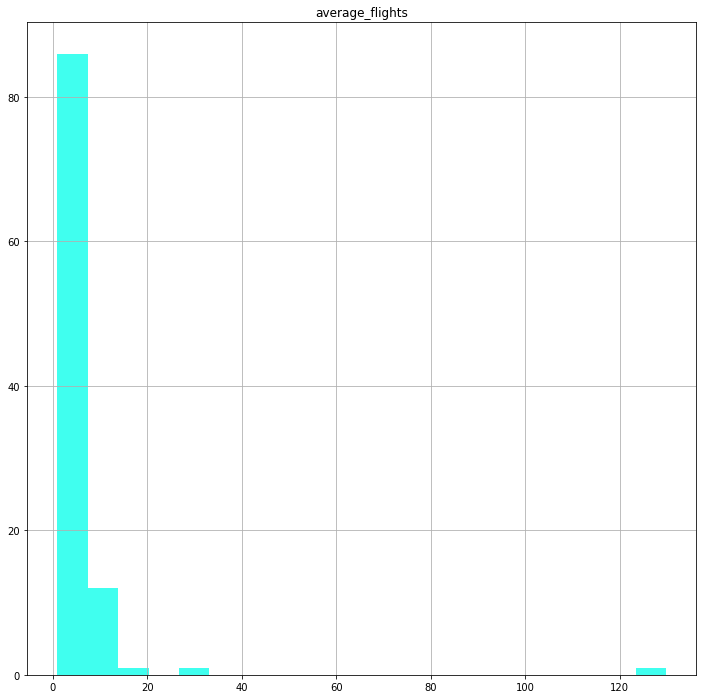


Описательные статистики категориальных признаков
----------------------------------------------------------------------------------------------------


In [9]:
view(c)

* так же все в порядке с таблицей о городах

### 2.Выберем ТОП 10 городов по количеству рейсов. <a id='100102'></a>

In [10]:
top_city = c.groupby(['city'])['average_flights'].sum().sort_values(ascending=False).reset_index()
top_city['average_flights'] = top_city['average_flights'].round().astype(int)
top_city.head(10)

,city,average_flights
0,Москва,130
1,Санкт-Петербург,31
2,Новосибирск,17
3,Красноярск,12
4,Екатеринбург,11
5,Ростов-на-Дону,10
6,Пермь,10
7,Брянск,10
8,Сочи,10
9,Ульяновск,10


### 3. Построим график количества выполненных рейсов по моделям самолетов. <a id='100103'></a>

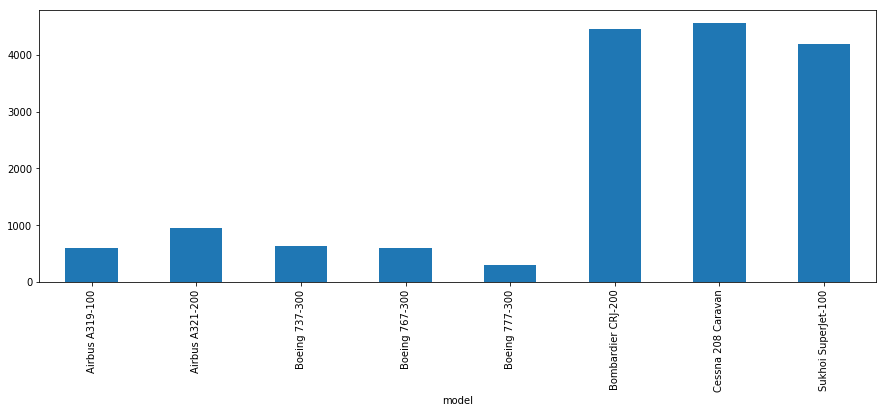

In [11]:
model_f = f.groupby(['model'])['flights_amount'].sum()
model_f.plot(y='flights_amount', kind='bar', figsize=(15, 5))

* Наибольшее количество рейсов выполняется на моделях самолетов: Bombardier CRJ-200 (50 мест), Cessna 208 Caravan (9-13 мест) и Sukhoi Superjet-100 (98 мест), причем с очень большим отрывом от других пяти моделей, если они выполняют до 1000 рейсов каждая, то на модели с самым большим количеством рейсов приходится более 4000 рейсов на каждую. Здесь нужно отметить, что модели с малым количеством рейсов могут перевозить каждый, в среднемв два с половиной раза больше пассажиров на бОльшие расстояния, так что можно сказать, что разница (если брать пассажировместимость) нивелируется, т.е. пассажиропоток этих двух типов самолетов оказывается примерно равен друг другу.

* **Можно сделать вывод, что (вполне естественно) модели самолетов способные перевозить малое количество людей на короткие расстояния совершают рейсов в 4 раза больше, чем самолеты предназначенные для полетов на дальние расстояния с высокой пассажировместимостью.**

### 4.Построим график количества выполненных рейсов в города. <a id='100104'></a>

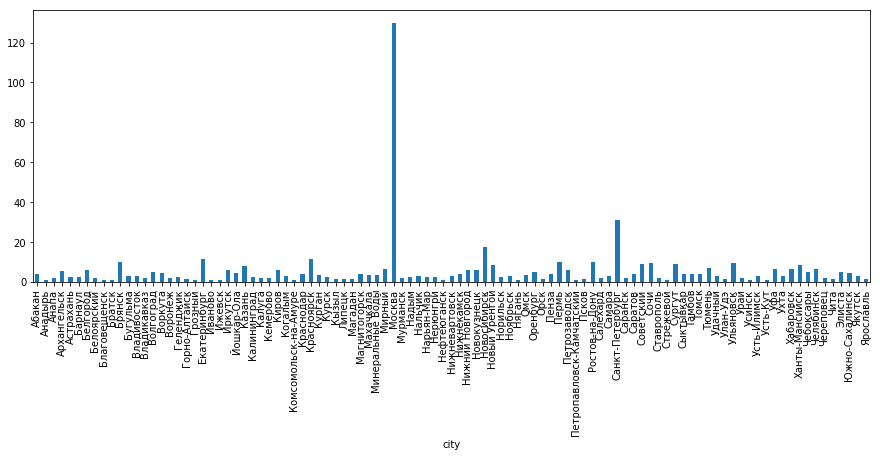

In [12]:
city_c = c.groupby(['city'])['average_flights'].sum()
city_c.plot(y='average_flights', kind='bar', figsize=(15, 5))

* На графике виден огромный отрыв города Москва по количеству совершаемых рейсов в день. На втором месте, правда с большой разницей с Москвой, Санкт-Петербург. На третьем - Новосибирск.

* Отрыв Москвы по рейсам, связан со стыковочными рейсами производимыми в другие страны и города России.

### 5.Построим график количества выполненных рейсов в топ-10 городов с самым большим трафиком. <a id='100105'></a>

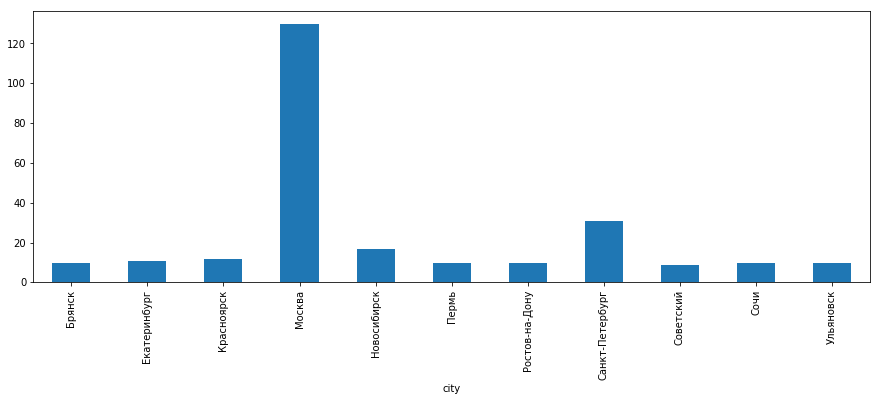

In [13]:
top_city1 = top_city.loc[:10]
top_city1 = top_city1.groupby(['city'])['average_flights'].sum()
top_city1.plot(y='average_flights', kind='bar', figsize=(15, 5))

* На этом графике хоть и топ-10, но отрыв Москвы, по-прежнему практически в 10 раз от всех остальных городов, кроме Санкт-Петербурга.

*посмотрим на сводную таблицу с билетами и фестивалями:*

In [14]:
bil

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


### 6. Проверка гипотезы: <a id='100106'></a>

**Проверим гипотезу от том, что средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.**
***************
* Нулевая это всегда равенство, поэтому возьмем в качестве нулевой гипотезы, что средние цены на билеты равны в любое время;
* проверку проведем по количеству проданных билетов.

*Разделим данные на 2 части:*

In [15]:
bil['festival_week'] = bil['festival_week'].fillna(0)
b1 = bil.query('festival_week > 0')
b1

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
6,36,51386,36.0,Видфест


In [16]:
b2 = bil.query('festival_week == 0')

b11 = b1['ticket_amount']
b22 = b2['ticket_amount']
variance_v_s = np.var(b11)
variance_v_u = np.var(b22)
print('Дисперсия выручки во время фестивалей', variance_v_s)
print('Дисперсия выручки в обычное время', variance_v_u)

Дисперсия выручки во время фестивалей 12998464.888888888
Дисперсия выручки в обычное время 14694.408163265309


In [17]:
b2 = b2.loc[7:9]
b2

,week_number,ticket_amount,festival_week,festival_name
7,37,51670,0.0,NaN
8,38,51518,0.0,NaN
9,39,51623,0.0,NaN


*теперь проверим гипотезу:*

In [18]:
h1 = b1['ticket_amount']
h2 = b2['ticket_amount']
alpha = .05
results = st.ttest_ind(
    h1,
    h2, equal_var=False)
results.pvalue

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую') 

Не получилось отвергнуть нулевую


* Из проверки гипотезы с большой вероятностью, можно сделать вывод, что проведение фестивалей не влияет на средний спрос на билеты.

### 7. Выводы: <a id='100107'></a>
* **Наибольшее количество рейсов выполняется на моделях самолетов предназначенных для перевозок на малые расстояния и небольшого количества пассажиров, причем они совершают в 4 раза больше рейсов более 4000 каждая модель, но если брать пассажиропоток этих двух типов самолетов, то он оказывается примерно равным.**
* **Рейсов совершаемых из Москвы в 10 раз больше в день, чем из любого другого города России, исключая Санкт-Петербург, разница здесь - примерно в 4 раза.**
* **Так же можно отметить, что проведение крупных фестивалей в различных городах, не влияет на средний спрос на билеты в эти города.**